This notebook may be used as a start for your exploration of time series analysis using multi-layer neural network, which weights are selected with NSGA-II algorithm with respect to two opposite criteria (objectives) of PICP and PINRW.

X.csv and F.csv in this folder contain the computed solution vectors as well as objectives values, where 1-PICP is the first column, PINRW is the second column.

The authors are:

Chervyakov A. - problem statement and analysis, methodology. <br>
Nikulchev E. - results validation and criticism. <br>
Gusev A. - data analysis, pipeline construction, code writing, tuning and testing. <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


2023-11-05 22:57:54.415004: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 22:57:54.512591: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-11-05 22:57:54.512608: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-05 22:57:55.043119: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared

In [4]:
!pip show pymoo || pip install pymoo
from pymoo.core.problem import ElementwiseProblem


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 4.4 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 6.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.1 MB/s eta 0:00:00:00:01
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210096 sha256=8b8aa8a7703e5ea968a425dade87281750b6712a49e5323df78f1b5a303fefbb
  Stored in directory: /home/alexander/.cache/pip/wheels/91/a8/bc/5b55a10f763ee2c066ff2d94058d7dd64d570fc45adc027b3d
Successfully built grapheme


In [4]:
import tensorflow as tf
import math
tf.executing_eagerly()

True

In [5]:
# Load the data
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D',
                   header=0,
                   usecols=['<DATE>', '<CLOSE>'],
                   parse_dates=['<DATE>'],
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%y'))

df = data[['<DATE>', '<CLOSE>']].copy()

In [6]:
df = df.sort_values('<DATE>')
df = df.reset_index(drop=True)



In [7]:
df.head()

,<DATE>,<CLOSE>
0,2003-03-03,352.24
1,2003-03-04,348.40
2,2003-03-05,357.65
3,2003-03-06,359.97
4,2003-03-07,354.87


In [8]:
df.tail()

,<DATE>,<CLOSE>
5005,2023-03-23,2388.35
5006,2023-03-24,2391.53
5007,2023-03-27,2440.68
5008,2023-03-28,2442.19
5009,2023-03-29,2444.90


In [2]:
def PICP(y_true, y_pred):

    n = tf.shape(y_pred)[0]
    c = tf.TensorArray(dtype=tf.float32, size=n)

    for i in tf.range(n):
        if y_true[i] >= y_pred[i][0] and y_true[i] <= y_pred[i][1]:
            c = c.write(i, 1.0)
        else:
            c = c.write(i, 0.0)

    return tf.reduce_sum(c.stack()) / tf.cast(n, dtype=tf.float32)

In [3]:
def PINRW(y_pred, R = 1.00):
    n = tf.shape(y_pred)[0]
    sum_of_squared_diff = tf.reduce_sum(tf.square(y_pred[:, 1] - y_pred[:, 0]))
    return tf.sqrt(sum_of_squared_diff / tf.cast(n, dtype=tf.float32)) / R


In [14]:
df.tail()

,<DATE>,<CLOSE>
5005,2023-03-23,2388.35
5006,2023-03-24,2391.53
5007,2023-03-27,2440.68
5008,2023-03-28,2442.19
5009,2023-03-29,2444.90


In [9]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

In [10]:
df[:train_size].tail()

,<DATE>,<CLOSE>
4003,2019-03-11,2465.94
4004,2019-03-12,2468.25
4005,2019-03-13,2470.61
4006,2019-03-14,2457.79
4007,2019-03-15,2476.73


In [11]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['<CLOSE>'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['<CLOSE>'].values.reshape(-1, 1))

In [23]:
X_test = test_scaled[:-1]
y_test = test_scaled[1:]

In [13]:
X_train = train_scaled[:-1]
y_train = train_scaled[1:]

In [20]:
X_train.shape

(4007, 1)

In [21]:
y_train.shape

(4007, 1)

In [22]:
X_test.shape

(1001, 1)

In [23]:
y_test.shape

(1001, 1)

In [14]:
# Define the model
model = Sequential([
    Dense(units=3),
    Dense(units=3),
    Dense(units=2)
])

# Build the model
input_shape = X_train.shape[1:]
model.build((None, *input_shape))

def get_shape(model):
    weights_layer = model.get_weights()
    shapes = []
    for weights in weights_layer:
        shapes.append(weights.shape)
    return shapes
def set_shape(weights,shapes):
    new_weights = []
    index=0
    for shape in shapes:
        if(len(shape)>1):
            n_nodes = np.prod(shape)+index
        else:
            n_nodes=shape[0]+index
        tmp = np.array(weights[index:n_nodes]).reshape(shape)
        new_weights.append(tmp)
        index=n_nodes
    return new_weights

2023-11-05 22:58:40.346090: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-11-05 22:58:40.346192: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-11-05 22:58:40.346268: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-11-05 22:58:40.346341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

In [15]:
shape = get_shape(model)

In [16]:
model.count_params()

26

In [49]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=model.count_params(),
                         n_obj=2,
                         xl=np.full(model.count_params(), -1),
                         xu=np.full(model.count_params(), 1)
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        global model, shape, X_train, y_train
        model.set_weights(set_shape(x,shape))
        predictions = model.predict(X_train)
        f1 = 1 - PICP(y_train, predictions)
        f2 = PINRW(predictions)

        out["F"] = [f1, f2]

problem = MyProblem()

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 6         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 2)                 8         
                                                                 
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [39]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)



In [40]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 500)

In [50]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

126/126 [==============================] - 0s 651us/step
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |      4 |             - |             -
126/126 [==============================] - 0s 639us/step
     2 |       50 |      5 |  0.0873247036 |         ideal
126/126 [==============================] - 0s 640us/step
     3 |       60 |      6 |  0.0402550462 |             f
126/126 [==============================] - 0s 635us/step
     4 |       70 |      6 |  0.000000E+00 |             f
126/126 [==============================] - 0s 633us/step
     5 |       80 |      5 |  0.0622384423 |             f
126/126 [==============================] - 0s 638us/step
     6 |       90 |      5 |  0.000000E+00 |             f
126/126 [==============================] - 0s 864us/step
     7 |      100 |      5 |  0.000000E+00 |             f
126/126 [==============================] - 0s 603us/step
     8 |      110 |      6 |  0.0194143240 |             f
126/126 [====

In [70]:
X_df = pd.DataFrame(X)

In [71]:
F_df = pd.DataFrame(F)

In [72]:
X_df.to_csv('X.csv')

In [73]:
F_df.to_csv('F.csv')

In [17]:
F_df = pd.read_csv('F.csv')
F = np.array(F_df.iloc[:,1:])
X_df = pd.read_csv('X.csv')
X = np.array(X_df.iloc[:,1:])

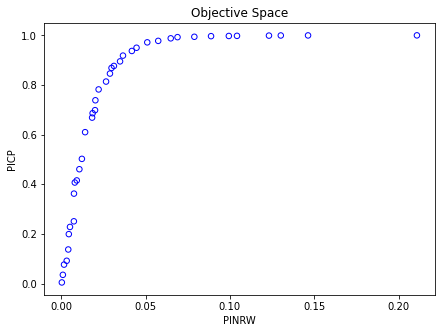

In [18]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 1], 1 - F[:, 0], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel('PINRW')
plt.ylabel('PICP')
plt.show()

In [24]:
y_test_unscaled = scaler.inverse_transform(y_test)

<H1> Predictions section:

Solution index  0
Train: PICP =  0.004492163658141979  PINRW =  0.000371632137103
Test: PICP =  0.0  PINRW =  0.0011125888


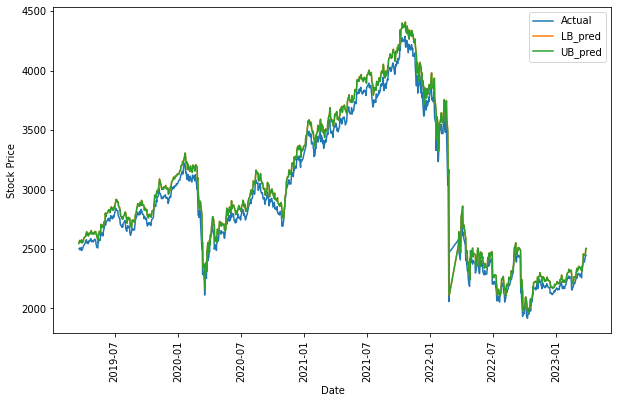

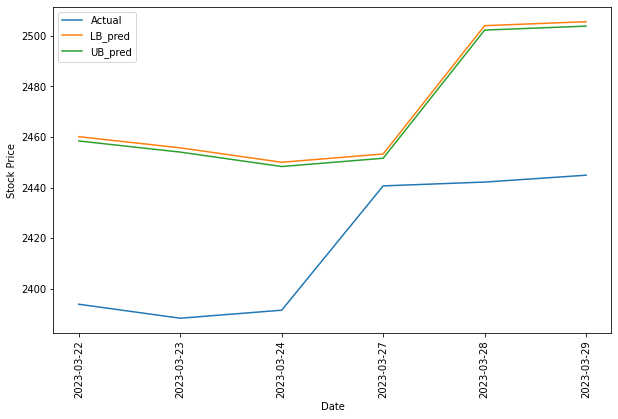

Solution index  1
Train: PICP =  1.0  PINRW =  0.2109114825725555
Test: PICP =  0.54845154  PINRW =  0.12712517


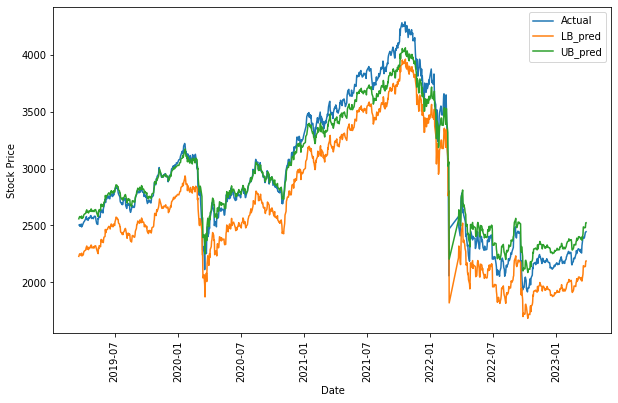

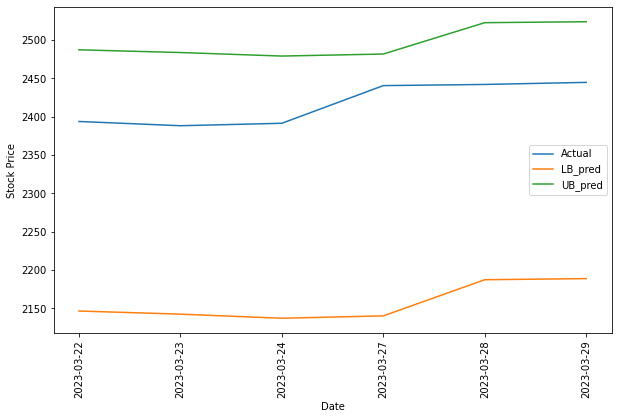

Solution index  2
Train: PICP =  0.9997504353523256  PINRW =  0.1463607549667358
Test: PICP =  0.96004  PINRW =  0.1355268


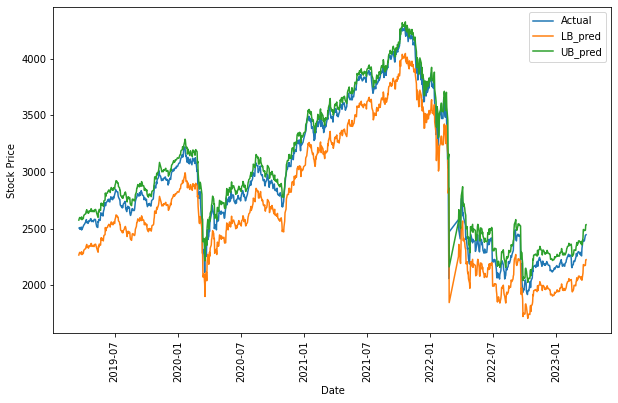

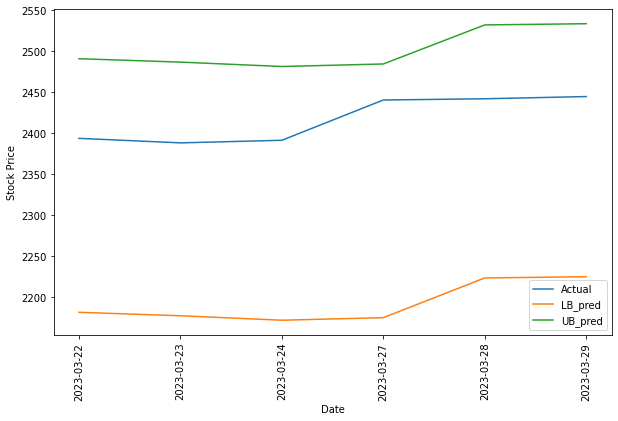

Solution index  3
Train: PICP =  0.36236584186553955  PINRW =  0.0075722597539424
Test: PICP =  0.14185815  PINRW =  0.00563921


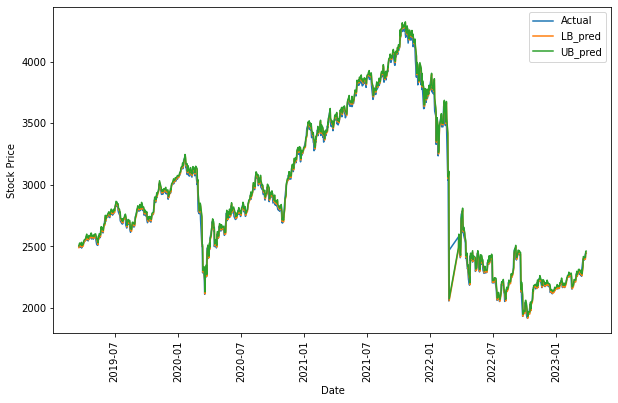

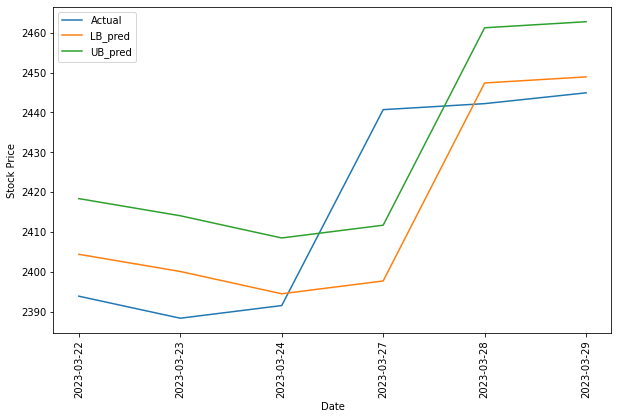

Solution index  4
Train: PICP =  0.2508111000061035  PINRW =  0.0075044687837362
Test: PICP =  0.043956045  PINRW =  0.0075652953


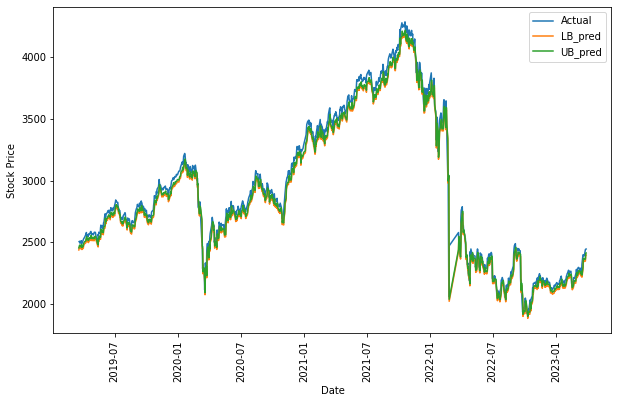

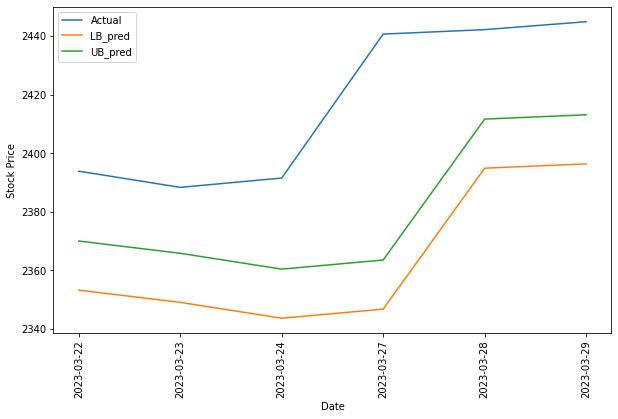

Solution index  5
Train: PICP =  0.9990017414093018  PINRW =  0.1231854856014251
Test: PICP =  0.953047  PINRW =  0.091102794


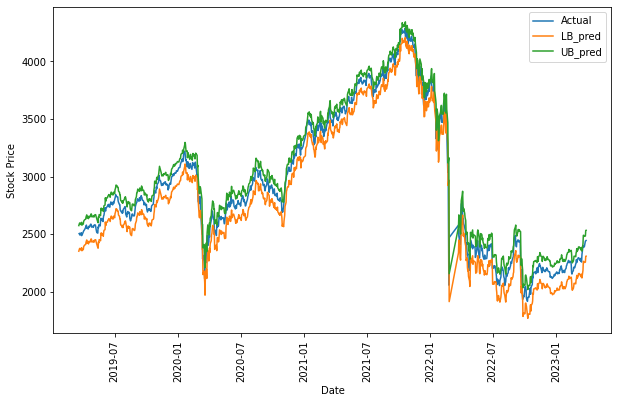

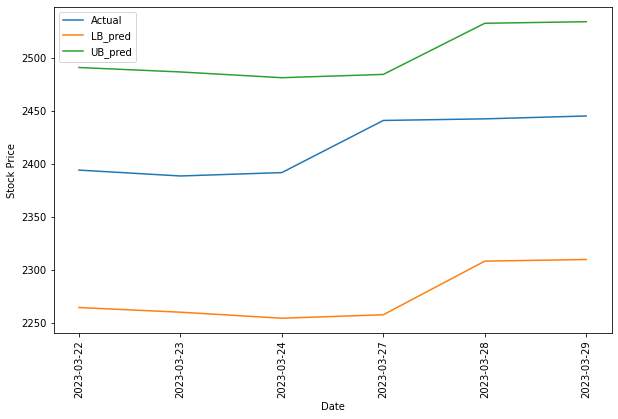

Solution index  6
Train: PICP =  0.9980034828186036  PINRW =  0.1042285934090614
Test: PICP =  0.95704293  PINRW =  0.08467973


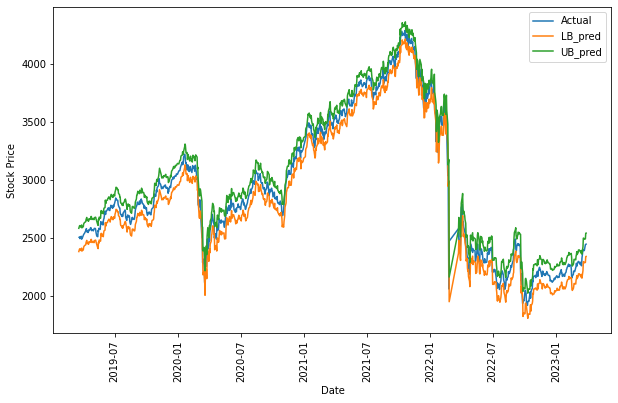

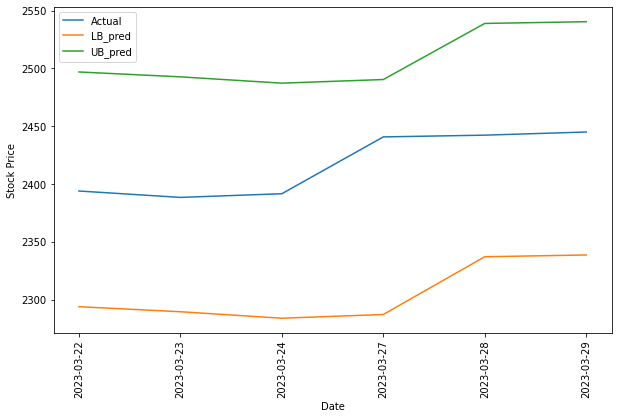

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/alexander/mambaforge/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3464, in run_code
    return outflag  File "/tmp/ipykernel_39571/4008002557.py", line 8, in <module>
    print('Test: PICP = ', 1 - PICP(y_test, y_pred).numpy(), ' PINRW = ', PINRW(y_pred).numpy())  File "/tmp/ipykernel_39571/2083903199.py", line 6, in PICP
    for i in tf.range(n):  File "/home/alexander/mambaforge/lib/python3.9/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
Solution index  7
Train: PICP =  0.13725978136062622  PINRW =  0.0041853664442896
Test: PICP =  0.32567433  PINRW =  0.011900909


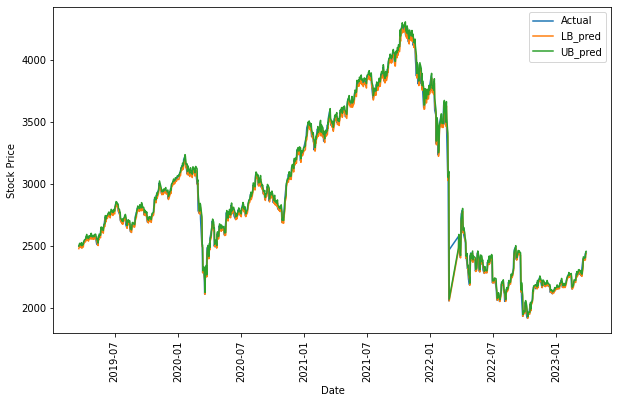

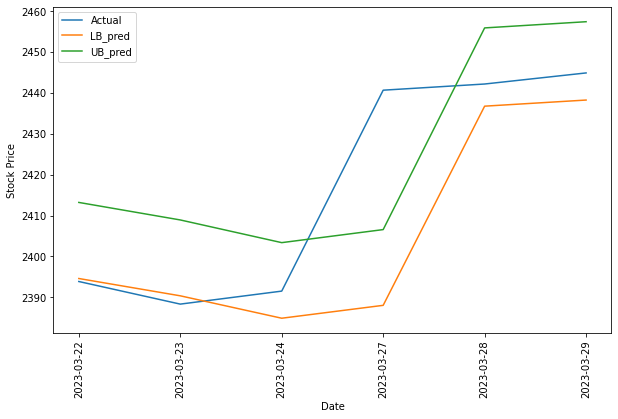

Solution index  8
Train: PICP =  0.9995008707046509  PINRW =  0.1301938444375991
Test: PICP =  0.83316684  PINRW =  0.075309165


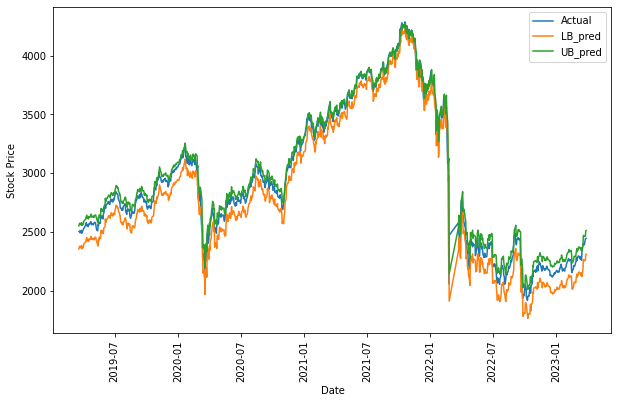

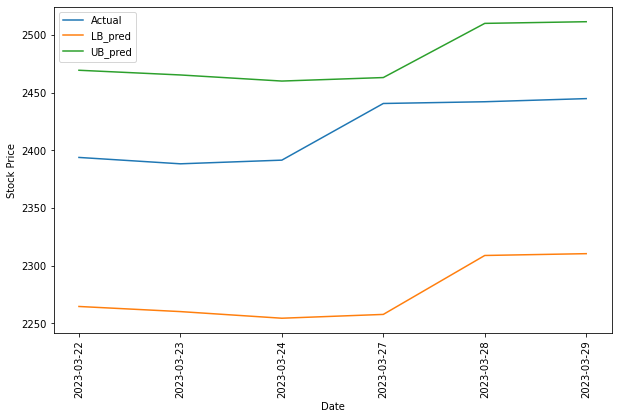

Solution index  9
Train: PICP =  0.6685799956321716  PINRW =  0.0183293595910072
Test: PICP =  0.7202797  PINRW =  0.032149523


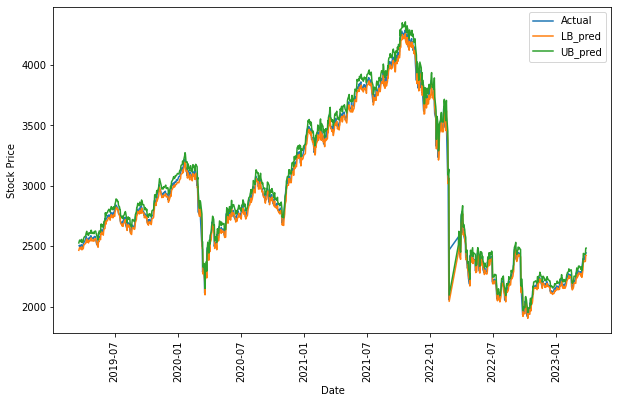

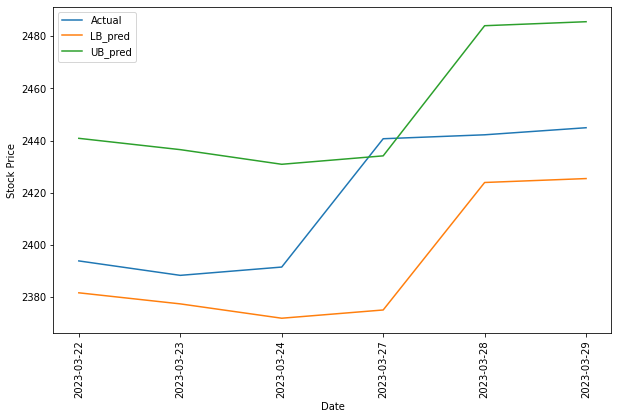

Solution index  10
Train: PICP =  0.7821312546730042  PINRW =  0.0221807230263948
Test: PICP =  0.8131868  PINRW =  0.039763175


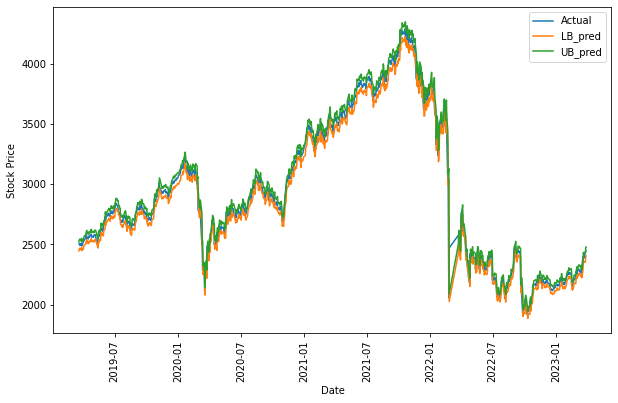

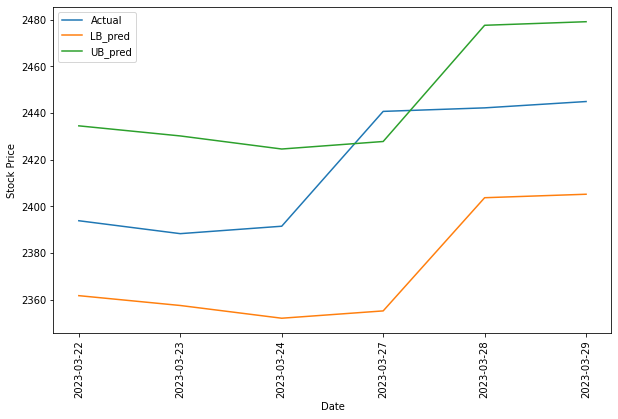

Solution index  11
Train: PICP =  0.4606937766075134  PINRW =  0.010774333961308
Test: PICP =  0.11188811  PINRW =  0.0050839284


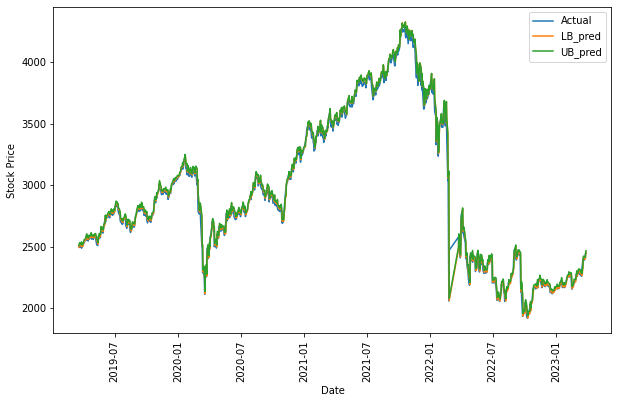

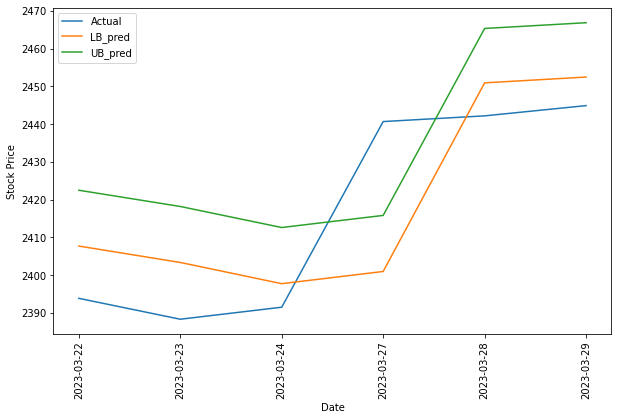

Solution index  12
Train: PICP =  0.9967556595802308  PINRW =  0.0888387635350227
Test: PICP =  0.9030969  PINRW =  0.061113052


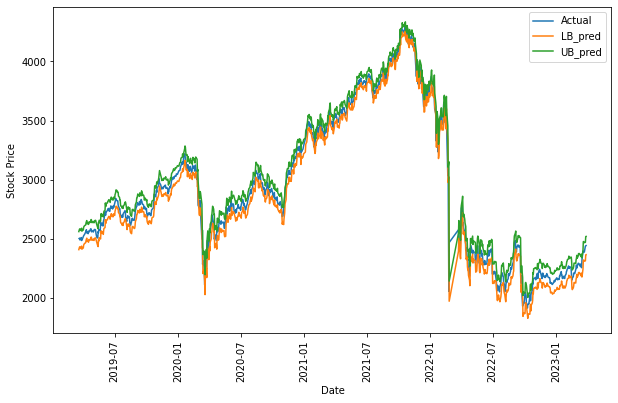

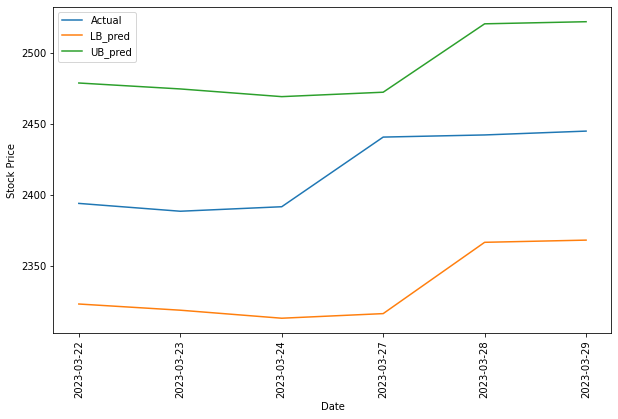

Solution index  13
Train: PICP =  0.9942600727081299  PINRW =  0.0789417773485183
Test: PICP =  0.92707294  PINRW =  0.07990122


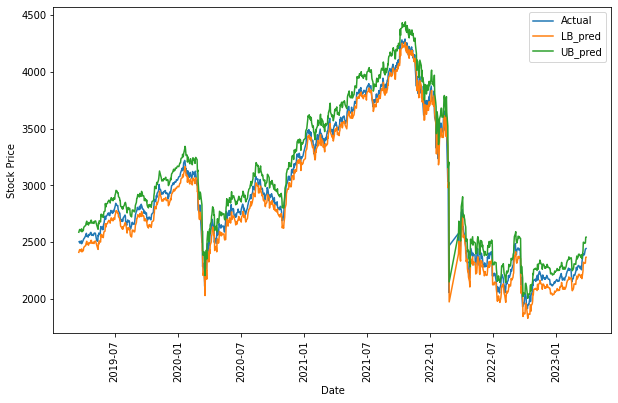

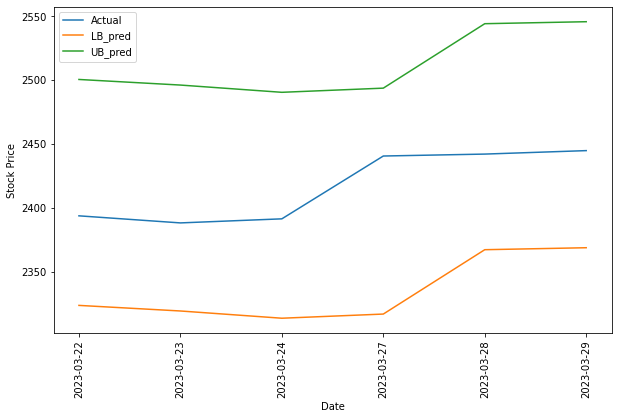

Solution index  14
Train: PICP =  0.813825786113739  PINRW =  0.0265939217060804
Test: PICP =  0.64035964  PINRW =  0.02568203


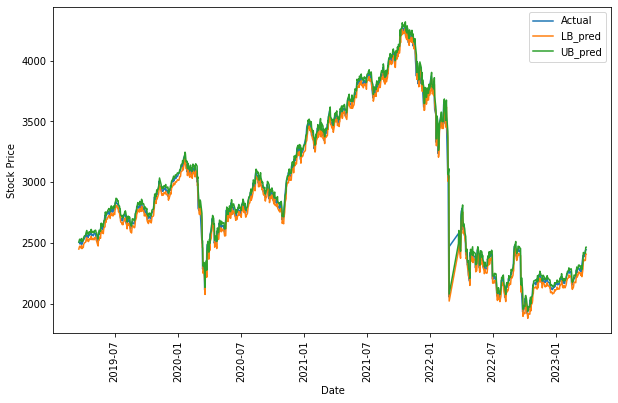

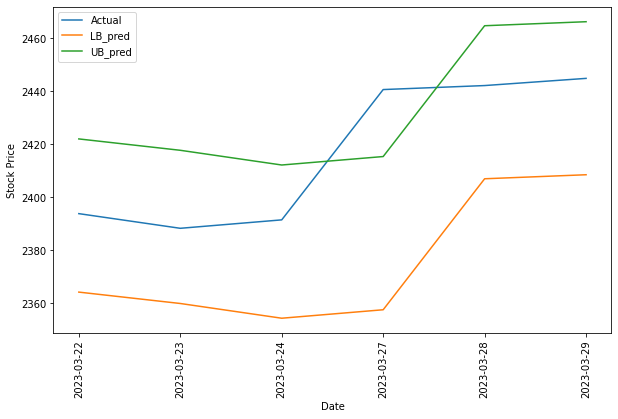

Solution index  15
Train: PICP =  0.19915151596069336  PINRW =  0.004511593375355
Test: PICP =  0.25674325  PINRW =  0.009064302


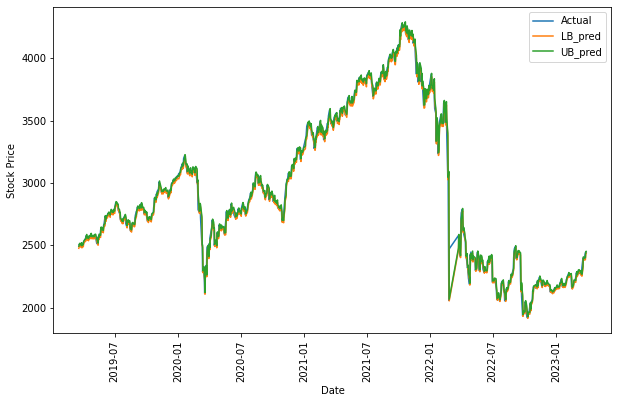

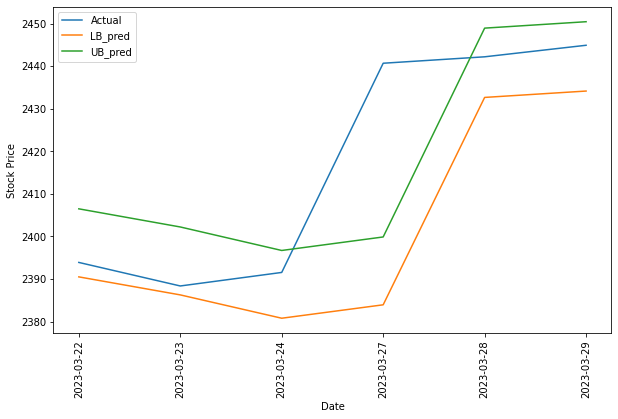

Solution index  16
Train: PICP =  0.971799373626709  PINRW =  0.0510279163718223
Test: PICP =  0.9170829  PINRW =  0.064570546


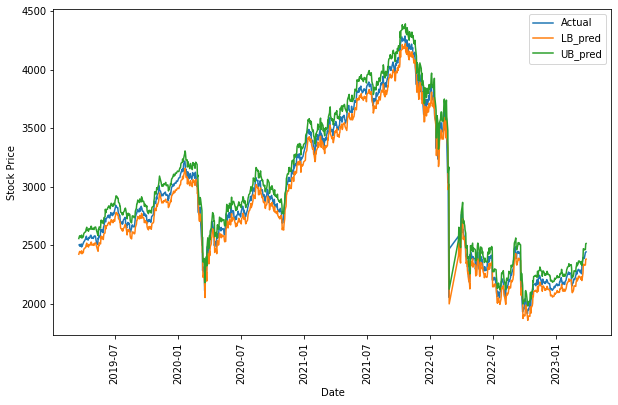

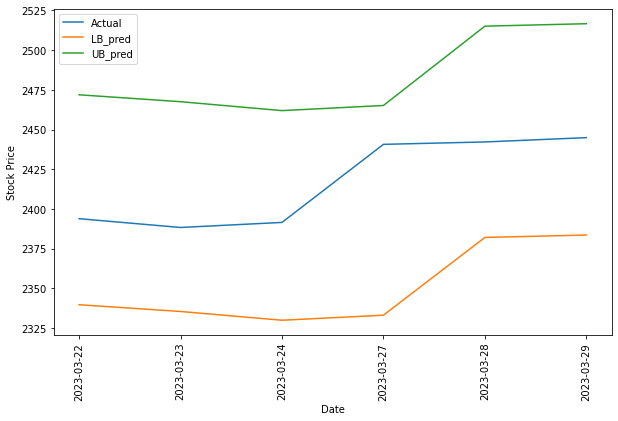

Solution index  17
Train: PICP =  0.846019446849823  PINRW =  0.0289035346359014
Test: PICP =  0.5764236  PINRW =  0.026620049


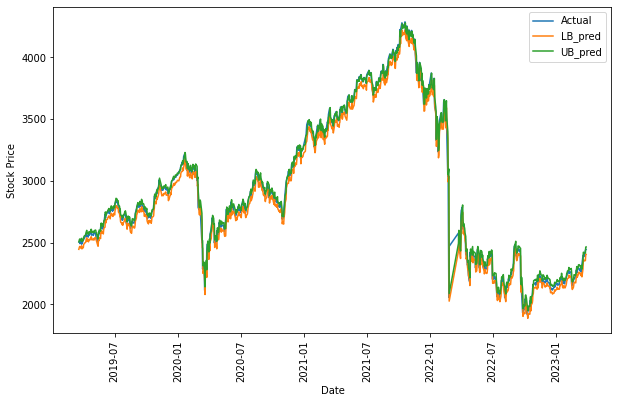

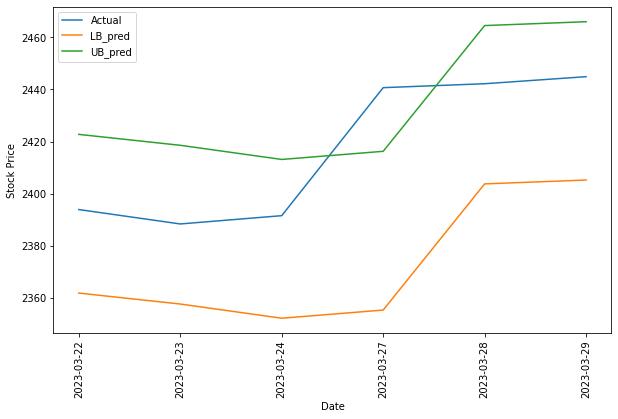

Solution index  18
Train: PICP =  0.5023708343505859  PINRW =  0.0122661786153912
Test: PICP =  0.10989011  PINRW =  0.0052233534


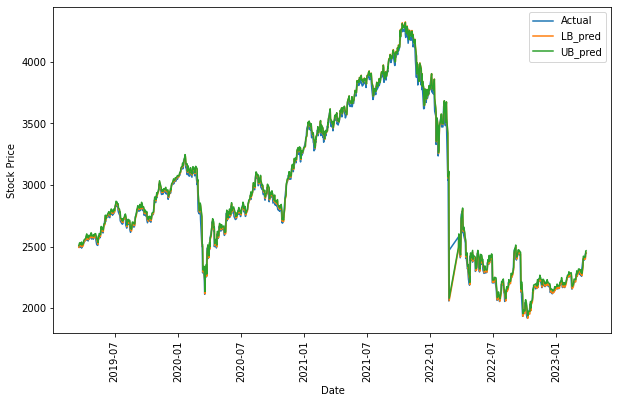

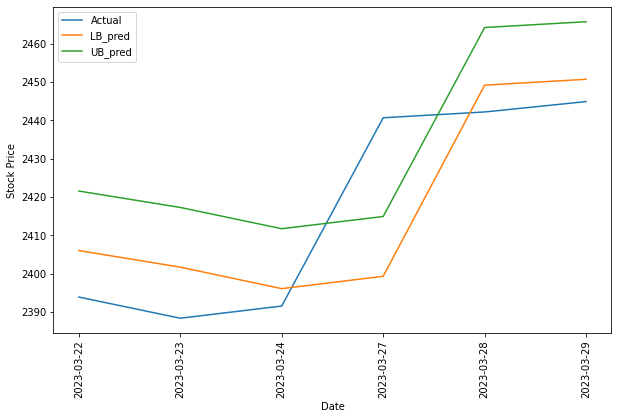

Solution index  19
Train: PICP =  0.9777888655662537  PINRW =  0.0575280673801898
Test: PICP =  0.9070929  PINRW =  0.05743059


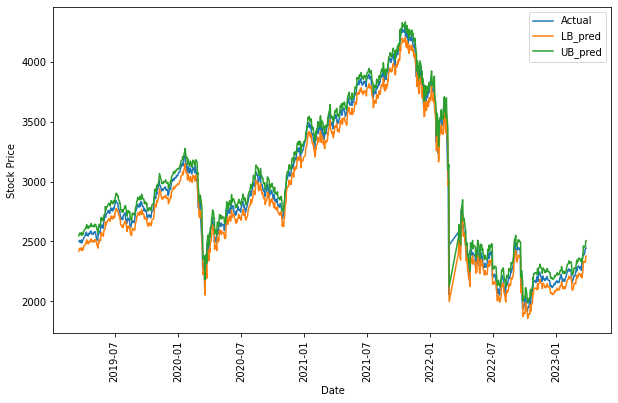

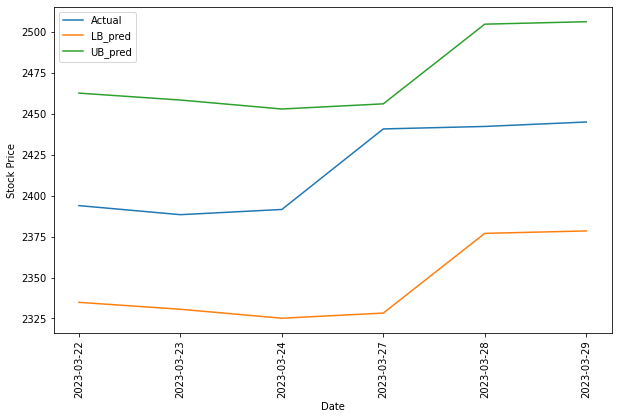

Solution index  20
Train: PICP =  0.03518843650817882  PINRW =  0.000984473968856
Test: PICP =  0.0  PINRW =  0.0018561498


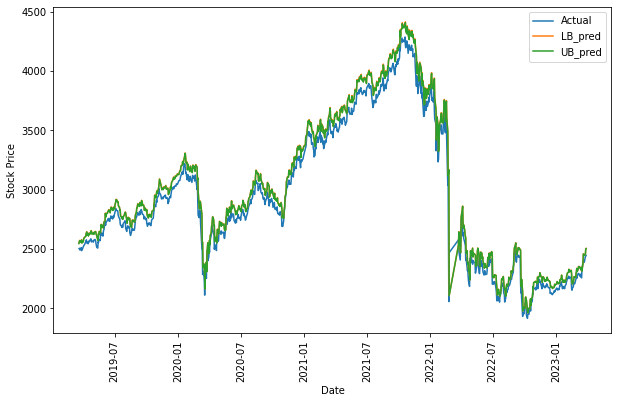

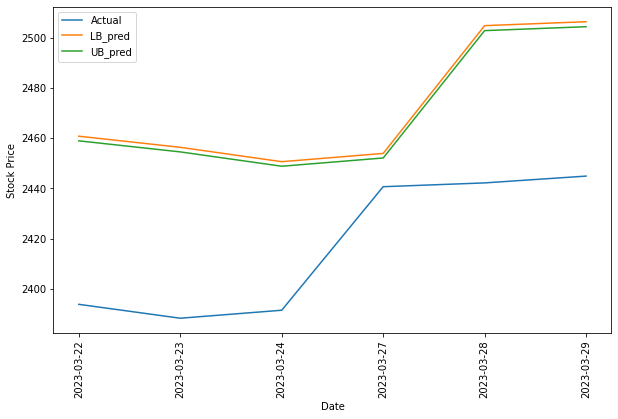

Solution index  21
Train: PICP =  0.9500873684883118  PINRW =  0.044664692133665
Test: PICP =  0.63836163  PINRW =  0.02879137


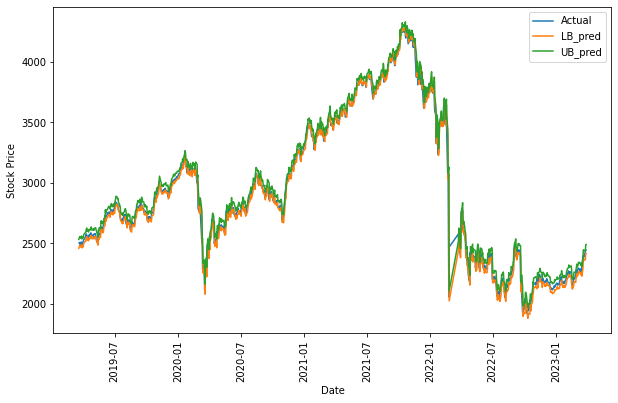

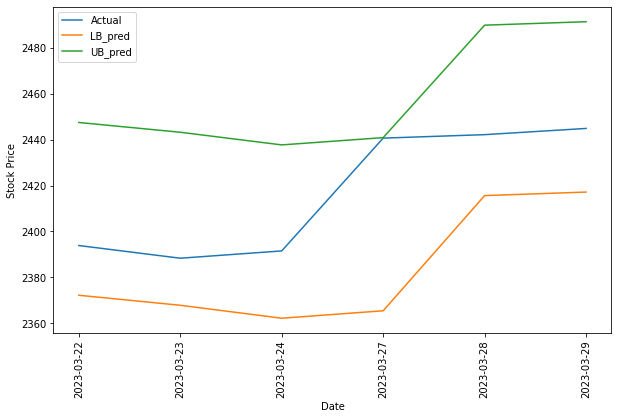

Solution index  22
Train: PICP =  0.8767157196998597  PINRW =  0.0312599651515483
Test: PICP =  0.8761239  PINRW =  0.049157564


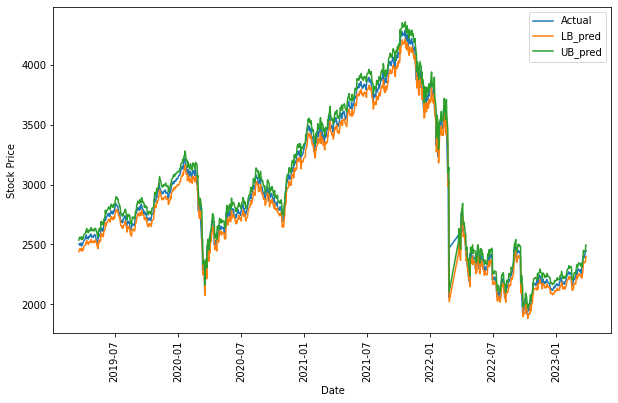

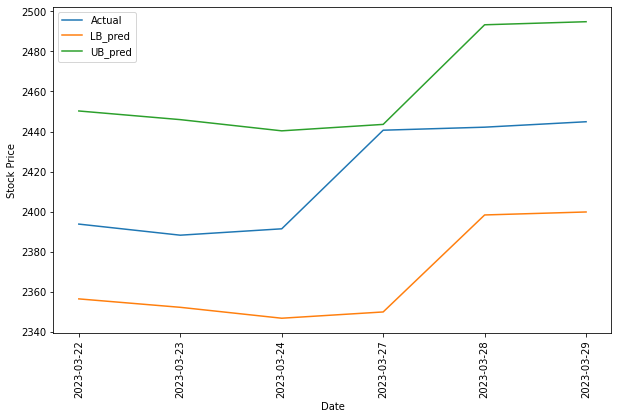

Solution index  23
Train: PICP =  0.6985275745391846  PINRW =  0.0200685802847147
Test: PICP =  0.1968032  PINRW =  0.008378259


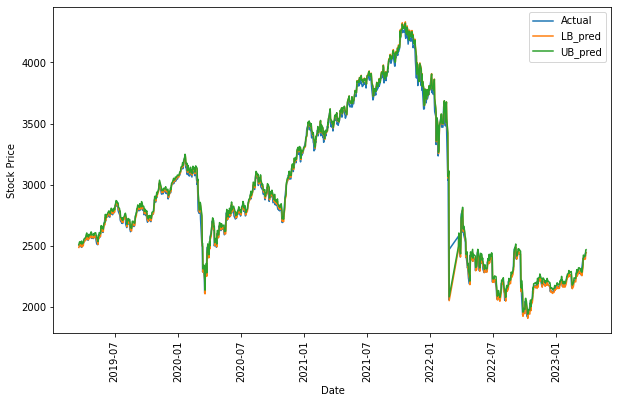

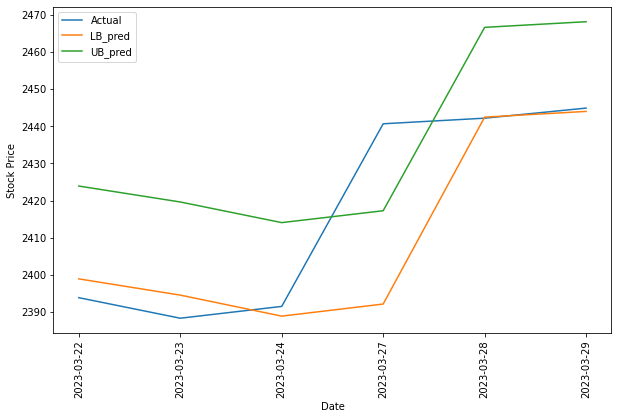

Solution index  24
Train: PICP =  0.9183928370475769  PINRW =  0.0366258770227432
Test: PICP =  0.7242757  PINRW =  0.031114584


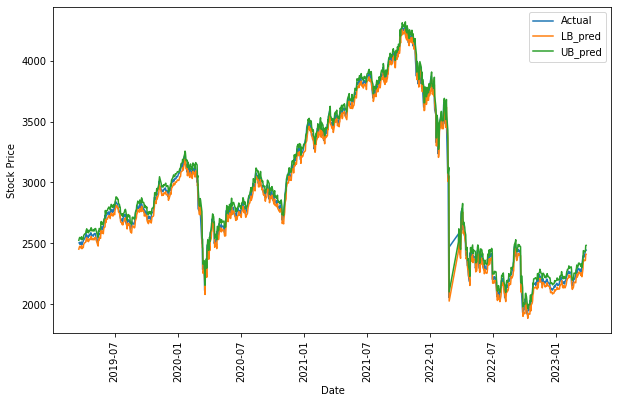

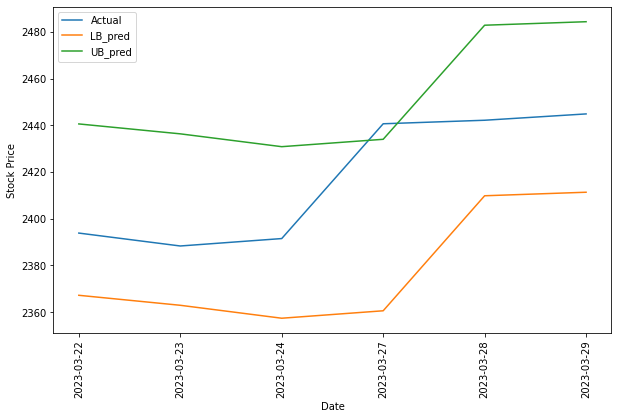

Solution index  25
Train: PICP =  0.9975043535232544  PINRW =  0.0993920043110847
Test: PICP =  0.94905096  PINRW =  0.09086796


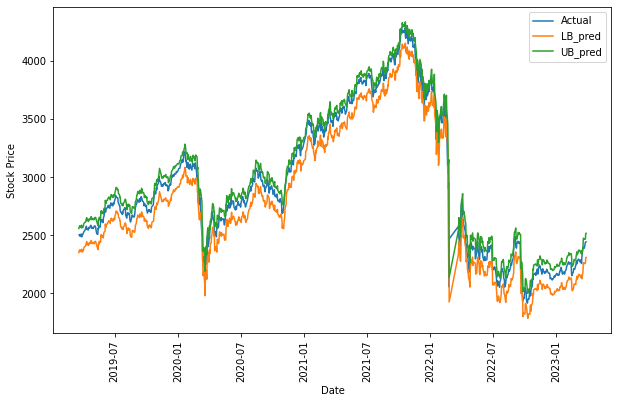

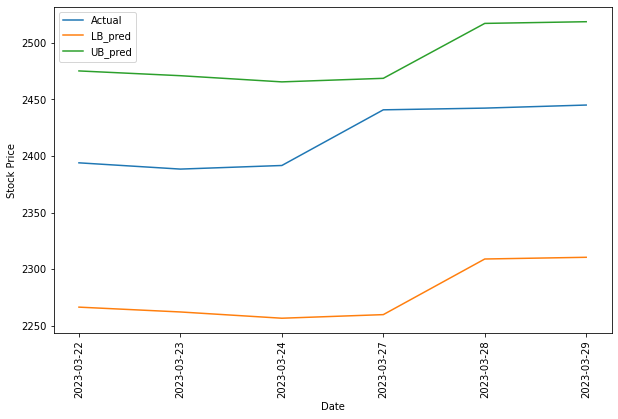

Solution index  26
Train: PICP =  0.09183931350707997  PINRW =  0.0032611158676445
Test: PICP =  0.2007992  PINRW =  0.0086427


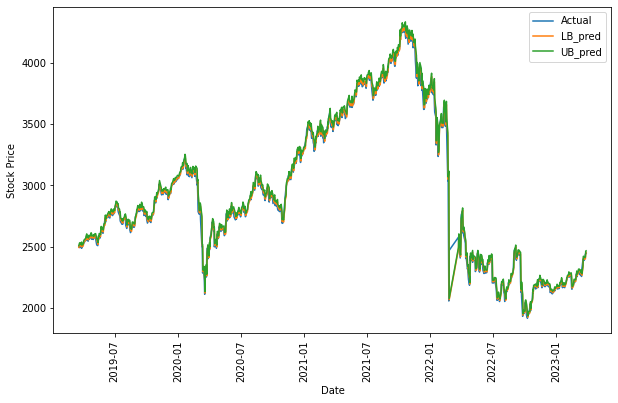

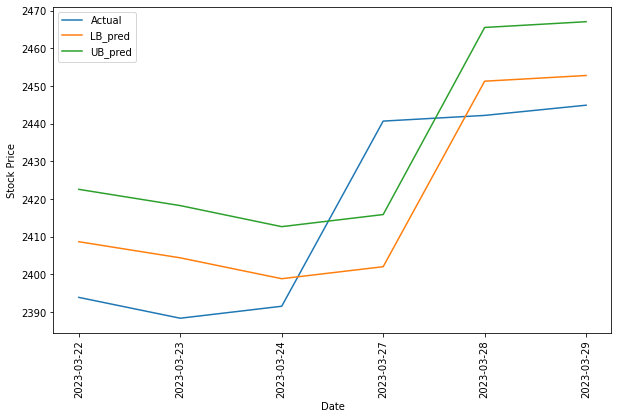

Solution index  27
Train: PICP =  0.9927626848220826  PINRW =  0.0689657926559448
Test: PICP =  0.86713284  PINRW =  0.049908515


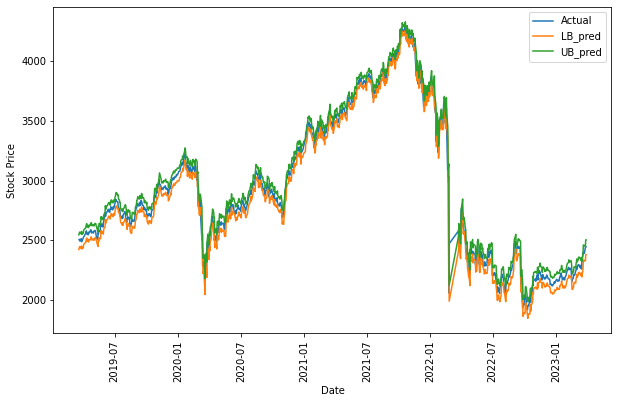

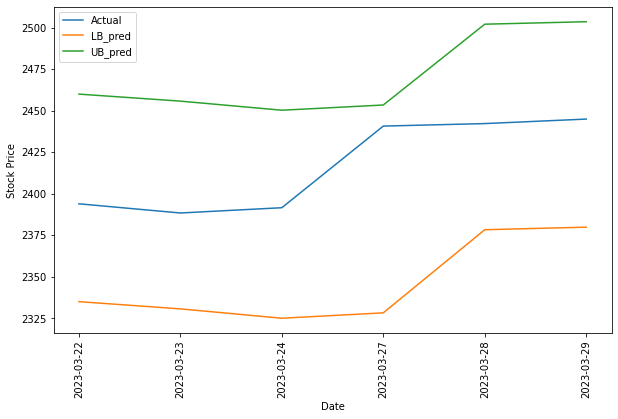

Solution index  28
Train: PICP =  0.9371100664138794  PINRW =  0.0418915338814258
Test: PICP =  0.8271728  PINRW =  0.047927197


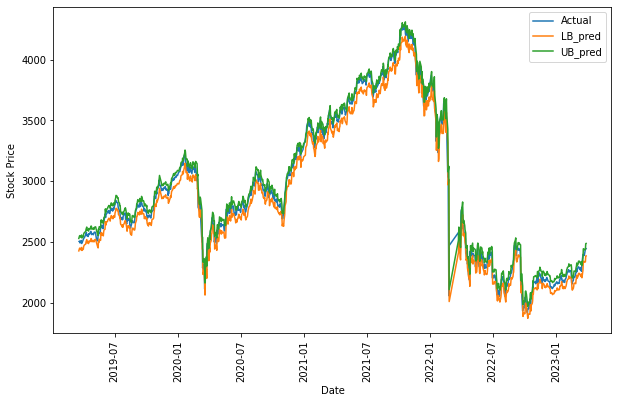

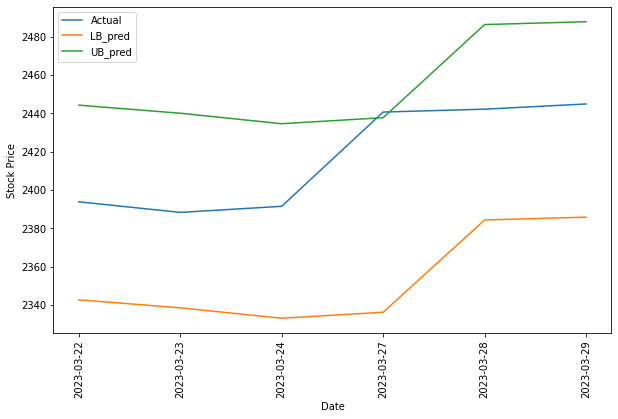

Solution index  29
Train: PICP =  0.9880209565162659  PINRW =  0.0649389326572418
Test: PICP =  0.8181818  PINRW =  0.044202533


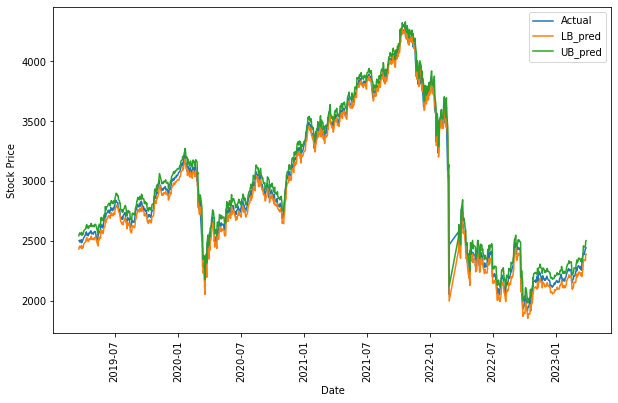

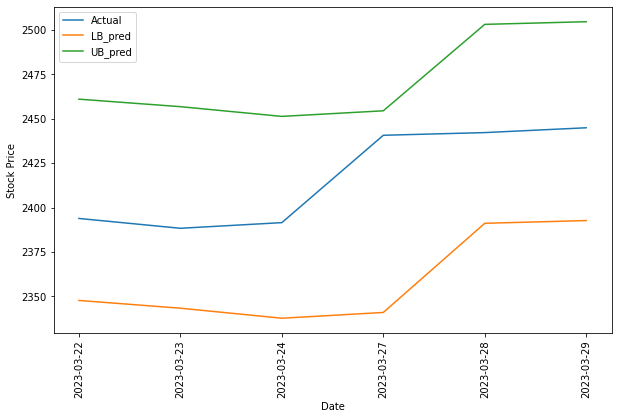

Solution index  30
Train: PICP =  0.07636636495590199  PINRW =  0.0016781648155301
Test: PICP =  0.055944055  PINRW =  0.0023518533


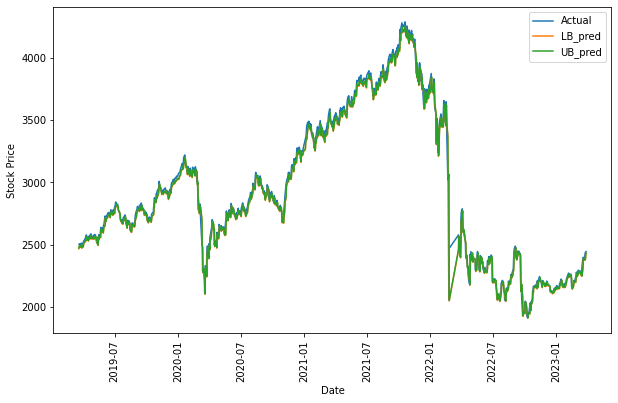

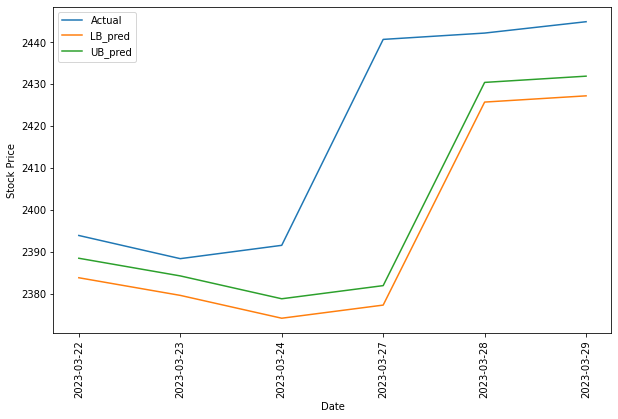

Solution index  31
Train: PICP =  0.8951834440231324  PINRW =  0.0348953083157539
Test: PICP =  0.8471528  PINRW =  0.055072065


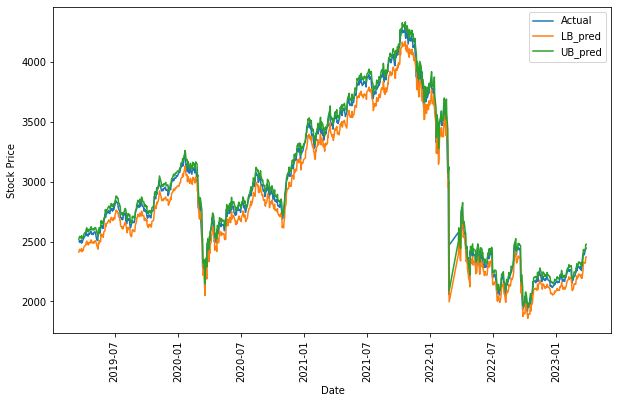

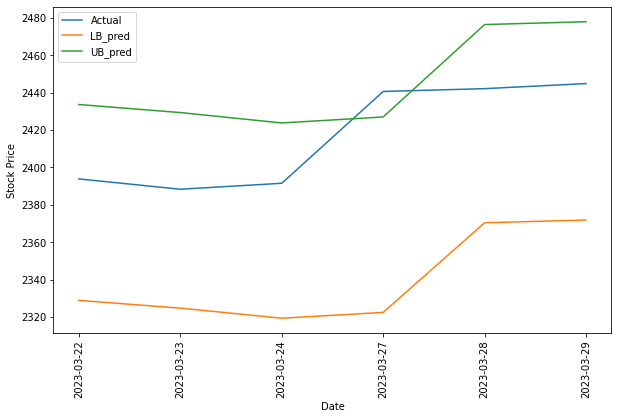

Solution index  32
Train: PICP =  0.41552281379699707  PINRW =  0.0092392023652791
Test: PICP =  0.17682318  PINRW =  0.007544193


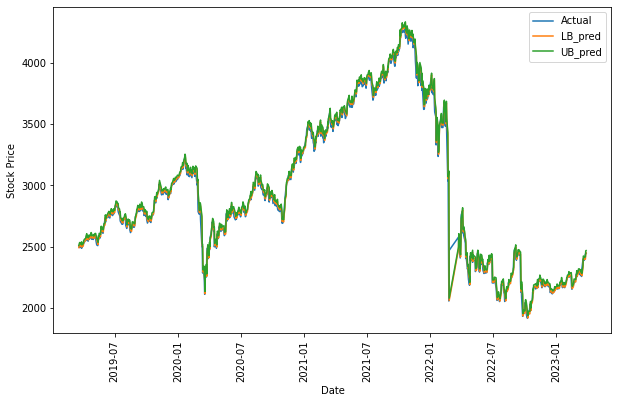

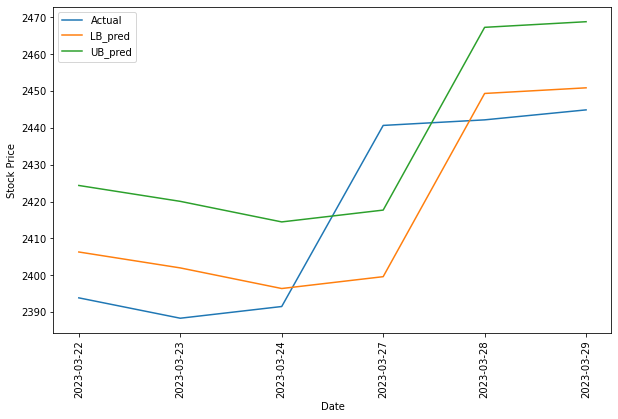

Solution index  33
Train: PICP =  0.22810083627700806  PINRW =  0.0052042813040316
Test: PICP =  0.28771228  PINRW =  0.011087709


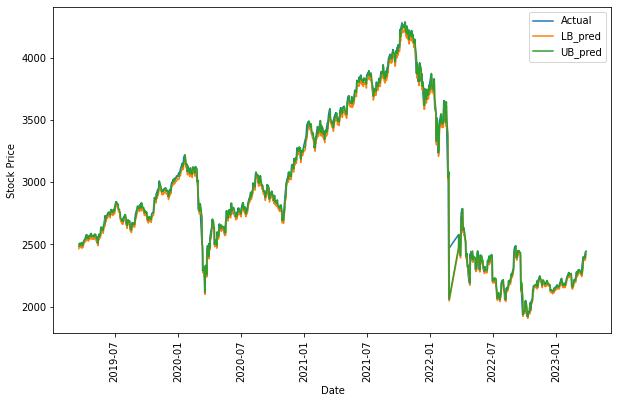

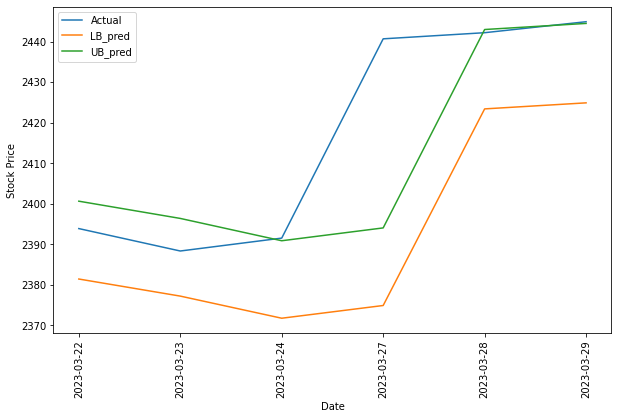

Solution index  34
Train: PICP =  0.4070376753807068  PINRW =  0.0080557558685541
Test: PICP =  0.08591408  PINRW =  0.0029309087


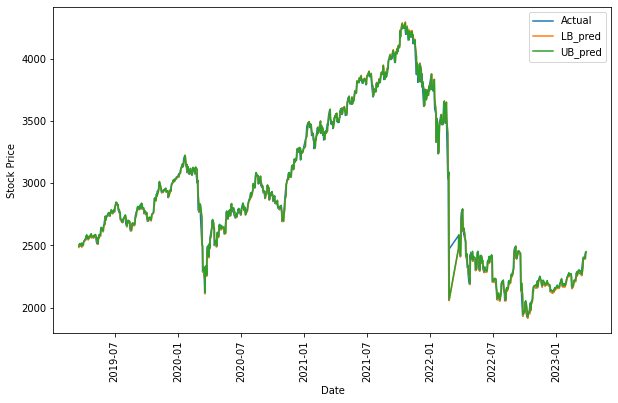

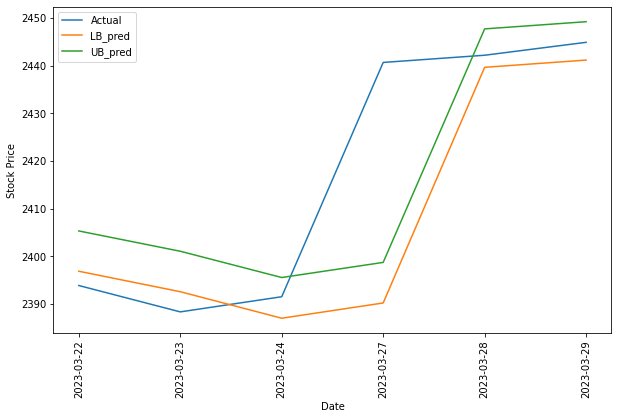

Solution index  35
Train: PICP =  0.7384576797485352  PINRW =  0.0202688742429018
Test: PICP =  0.76123875  PINRW =  0.036475997


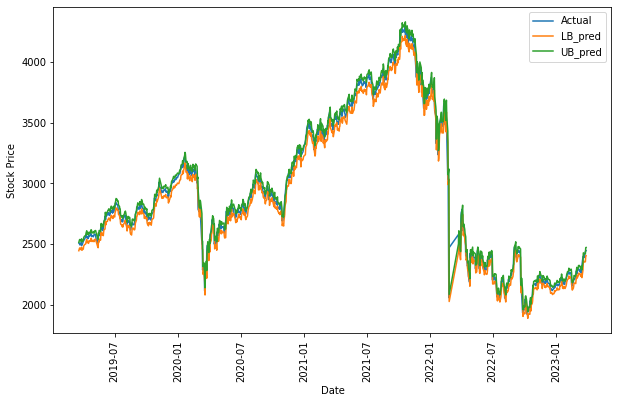

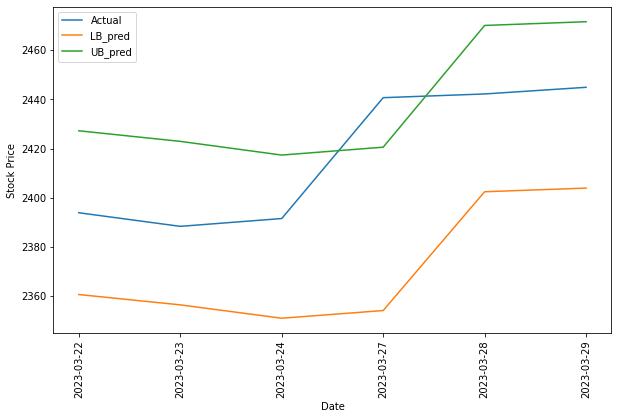

Solution index  36
Train: PICP =  0.6099326014518738  PINRW =  0.0141792185604572
Test: PICP =  0.4765235  PINRW =  0.017966436


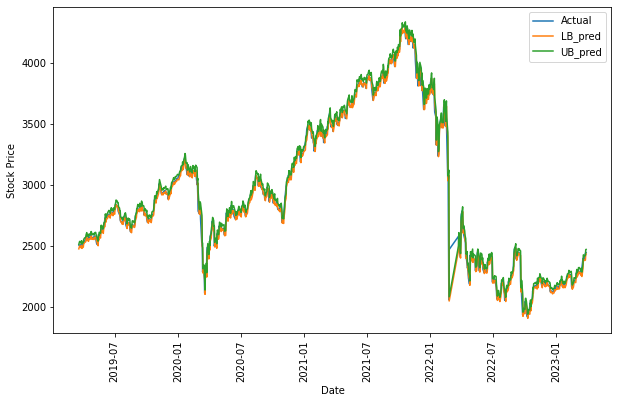

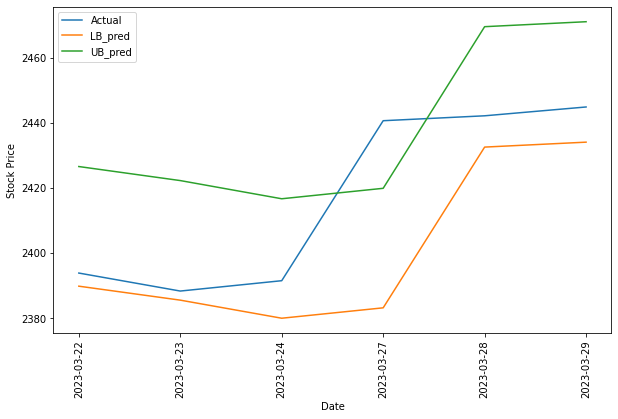

Solution index  37
Train: PICP =  0.8687297105789185  PINRW =  0.0298325214534997
Test: PICP =  0.6733267  PINRW =  0.034091484


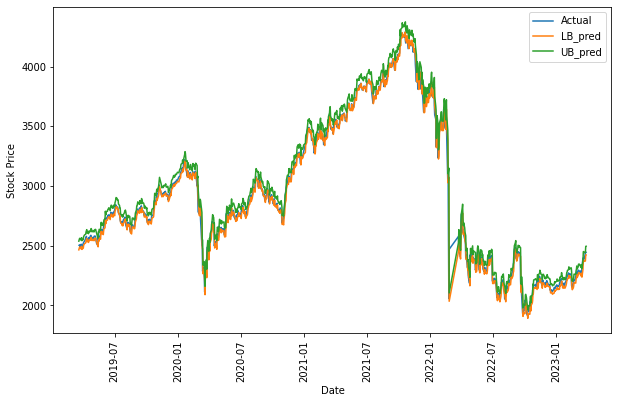

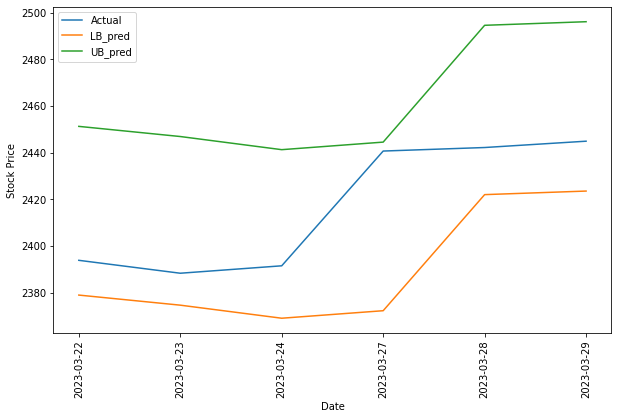

Solution index  38
Train: PICP =  0.6862989664077759  PINRW =  0.0186251662671566
Test: PICP =  0.68931067  PINRW =  0.02751423


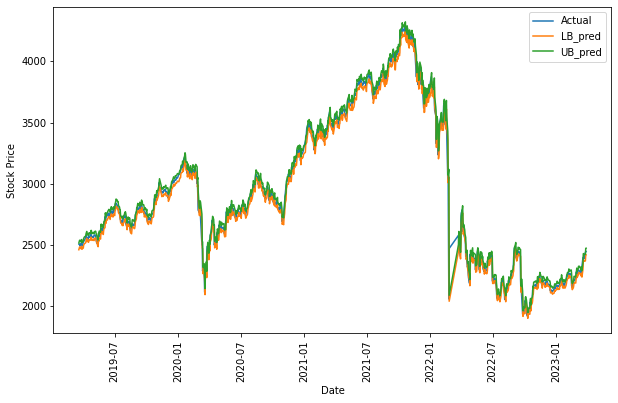

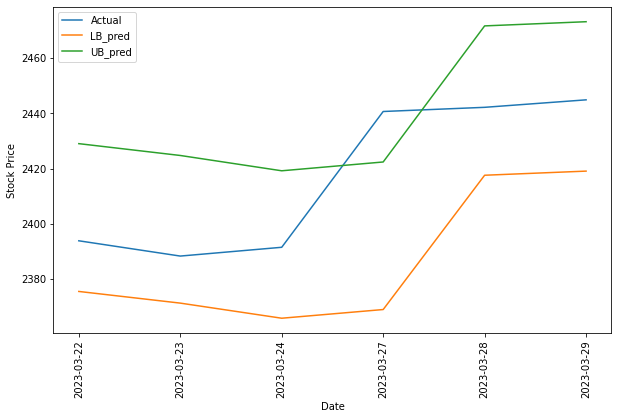

In [34]:
PICP_test = []
PINRW_test = []

for sol_ind in range(len(X)):
    model.set_weights(set_shape(X[sol_ind],shape))
    y_pred = model.predict(X_test, verbose = False)
    print('Solution index ', sol_ind)
    print('Train: PICP = ', 1 - F[sol_ind, 0], ' PINRW = ', F[sol_ind, 1])
    print('Test: PICP = ', PICP_t:= PICP(y_test, y_pred).numpy(), ' PINRW = ', PINRW_t:= PINRW(y_pred).numpy())
    PICP_test.append(PICP_t)
    PINRW_test.append(PINRW_t)
    
    
    y_pred = scaler.inverse_transform(y_pred)


    # Plot the actual and predicted stock prices with the upper and lower bounds
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(test['<DATE>'][2:], y_test_unscaled[1:], label='Actual')

    ax.plot(test['<DATE>'][1:], y_pred[:,0], label='LB_pred')
    ax.plot(test['<DATE>'][1:], y_pred[:,1], label='UB_pred')


    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock Price')
    plt.xticks(rotation=90)
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 6))

    last_dates = ('2023-03-22','2023-03-23','2023-03-24','2023-03-27','2023-03-28','2023-03-29')

    ax.plot(last_dates, y_test_unscaled[-6:], label='Actual')

    ax.plot(last_dates, y_pred[-6:,0], label='LB_pred')
    ax.plot(last_dates, y_pred[-6:,1], label='UB_pred')

    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock Price')
    plt.xticks(rotation=90)
    plt.show()

In [43]:
metrics_df = pd.DataFrame({'PICP_train': 1 - F[:, 0], 'PINRW_train': F[:, 1], 'PICP_test': PICP_test, 'PINRW_test': PINRW_test})


In [44]:
metrics_df.to_csv('metrics.csv')